In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from array import *
%matplotlib inline
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
from IPython.display     import Image
import os

In [2]:
current_path = os.getcwd()
parent_directory = os.path.dirname(os.path.dirname(current_path))

folders = parent_directory+"\\Electrolyte_Calibration\\"
folder2 = parent_directory+"\\Lydia_data\\Battery_Data\\"

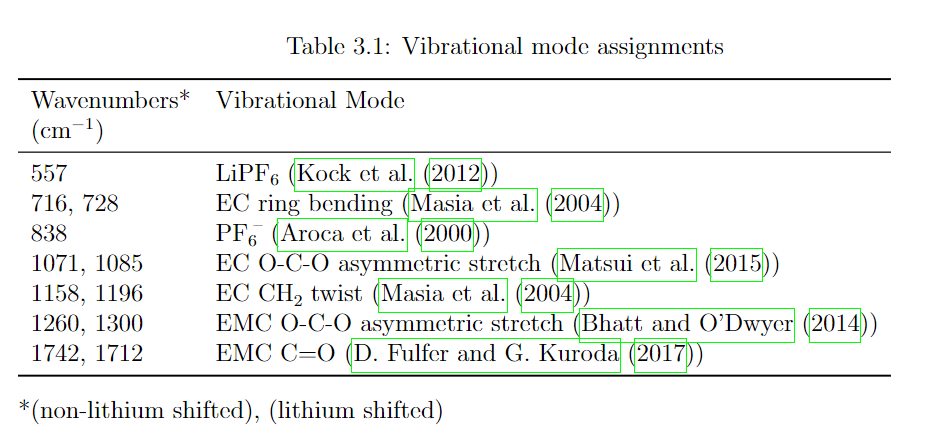

In [3]:
Image(filename="peak_assignments.png")

In [4]:
#Load in Data
B = np.array(pd.read_csv(folders+"Background Background_3_25_24.tsv",sep="\t")) #Background
wn = np.array(pd.read_csv(folders+"0M_3_26_24v2.tsv",sep="\t"))[:,0] #Wavenumber set
M0 = np.array(pd.read_csv(folders+"0M_3_26_24v2.tsv",sep="\t"))[:,1] #0M
M4 = np.array(pd.read_csv(folders+"-4M_3_25_24.tsv",sep="\t"))[:,1] #.4M
M7 = np.array(pd.read_csv(folders+"-7M_3_25_24.tsv",sep="\t"))[:,1] #.7M
M1 = np.array(pd.read_csv(folders+"1M_3_25_24.tsv",sep="\t"))[:,1] #1M
M13 = np.array(pd.read_csv(folders+"1-3M_3_25_24.tsv",sep="\t"))[:,1] #1.3M
M16 = np.array(pd.read_csv(folders+"1-6M_3_25_24.tsv",sep="\t"))[:,1] #1.6M


Use Beer's law to calculate absorbance using natural log: $A=-log_{10}(I/I_0)$

In [5]:
A0 = -np.log10(M0/B[:,1])
A4 = -np.log10(M4/B[:,1])
A7 = -np.log10(M7/B[:,1])
A1 = -np.log10(M1/B[:,1])
A13 = -np.log10(M13/B[:,1])
A16 = -np.log10(M16/B[:,1])

Text(0.5, 1.0, "Schuyler's mixture")

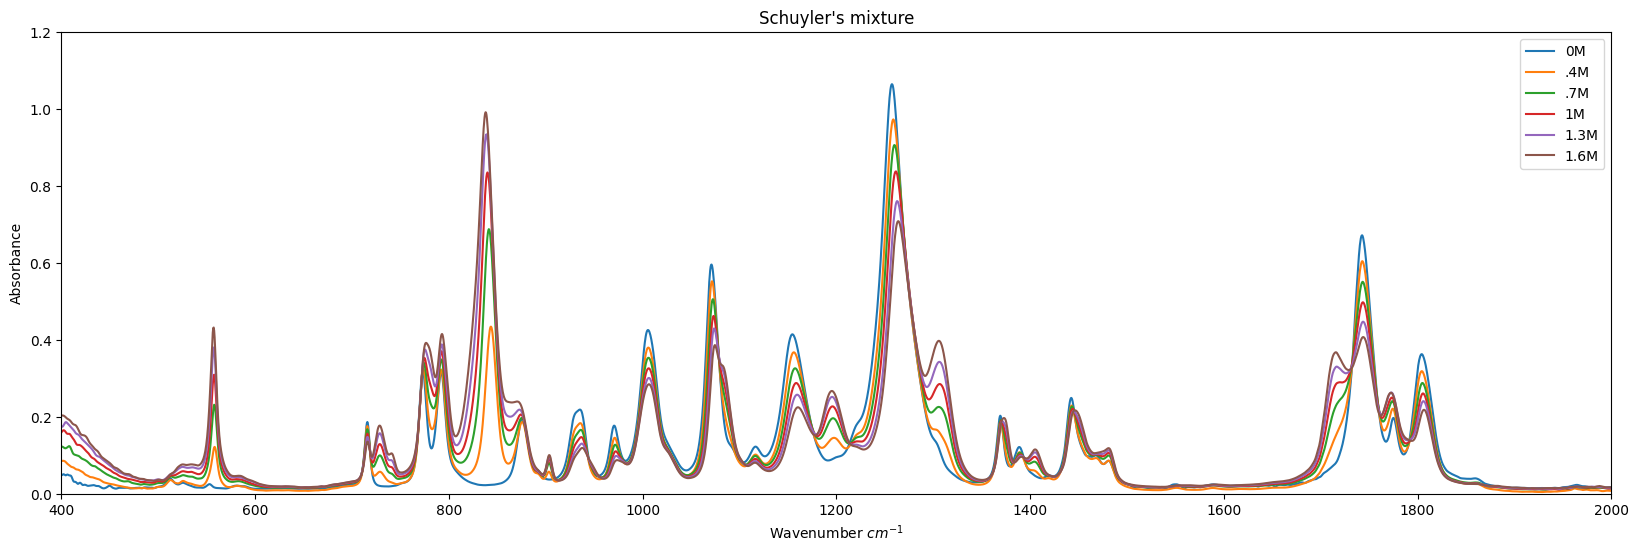

In [6]:
plt.figure(figsize=(20,6))
plt.plot(wn,A0,label="0M")
plt.plot(wn,A4,label=".4M")
plt.plot(wn,A7,label=".7M")
plt.plot(wn,A1,label="1M")
plt.plot(wn,A13,label="1.3M")
plt.plot(wn,A16,label="1.6M")
plt.legend()
plt.xlim(400,2000)
plt.ylim(0,1.2)
plt.ylabel("Absorbance")
plt.xlabel("Wavenumber $cm^{-1}$")
#print(len(wn))
plt.title("Schuyler's mixture")

Interpolate Lydia's data for known concentrations and use residual (difference between my data and the interpolation at the same concentrations) to calculate a percent error for my data.

In [7]:
Mol = np.array(pd.read_csv(folder2+"spectral_database_battery_elytes_molarity.csv"))
Time = pd.read_csv(folder2+'spectral_data_battery_test_time.csv',header = None).T
Absorb = np.array(pd.read_csv(folder2+"spectral_data_battery_test_absorbance.csv"))

In [8]:
concentrations = np.array([0,.6,.8,1,1.2,1.4,1.8])
absorbances = np.array([Mol[:,1],Mol[:,2],Mol[:,3],Mol[:,4],Mol[:,5],Mol[:,6],Mol[:,7]])
print(absorbances)

[[ 0.00271526  0.00224899  0.00164481 ...  0.01318899  0.01328074
   0.01339278]
 [-0.00140687 -0.00146702 -0.00162412 ...  0.01476262  0.01483705
   0.01488434]
 [ 0.00059857  0.00076013  0.00089195 ...  0.01146672  0.01163618
   0.01180222]
 ...
 [-0.00135696 -0.00159668 -0.00176277 ...  0.01049196  0.01056565
   0.01064288]
 [ 0.00058756  0.00074838  0.00062362 ...  0.0118092   0.01190284
   0.01201487]
 [-0.00028467 -0.00082894 -0.00116765 ...  0.0135004   0.01360428
   0.01369103]]


Text(0.5, 1.0, "Interpolated Values from Lydia's Data")

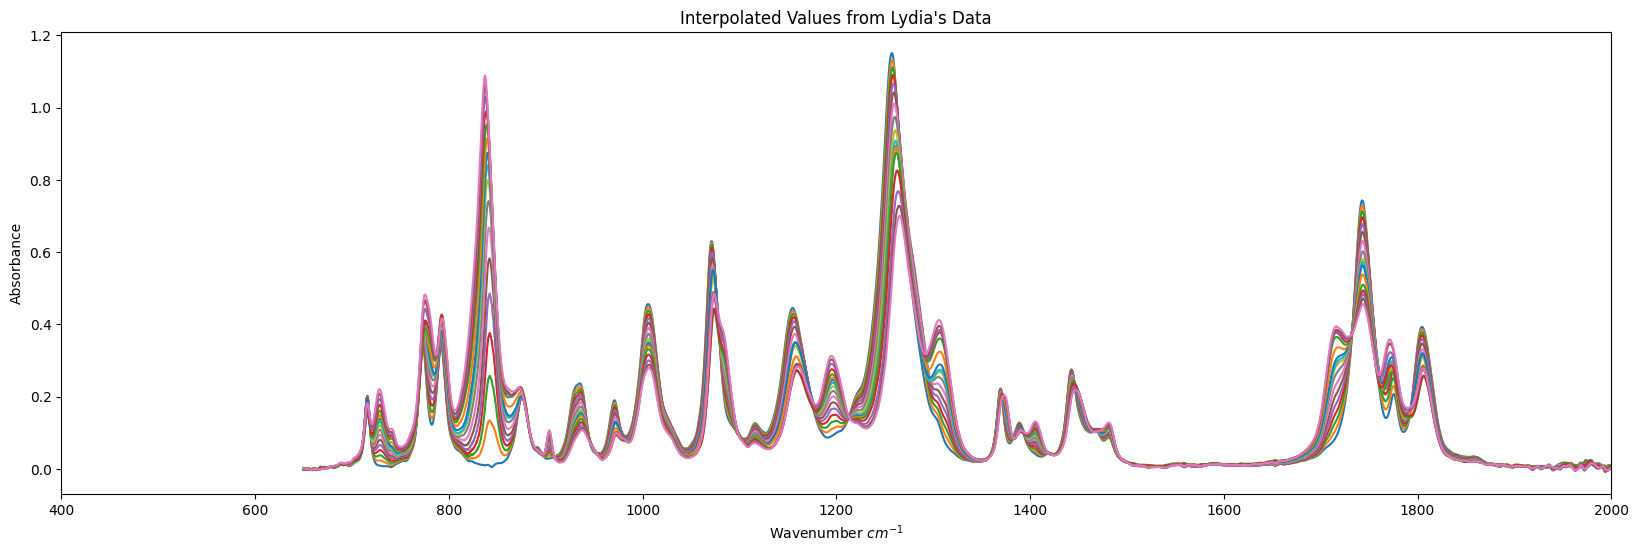

In [9]:
wavenumbers = Mol[:,0]

# Create an array for the new concentrations from 0M to 1.6M
new_concentrations = np.linspace(0, 1.6, 17)

# Create a 2D grid for the new concentrations and wavenumbers
new_concentrations_grid, wavenumbers_grid = np.meshgrid(new_concentrations, wavenumbers)

# Flatten the arrays for the griddata function
points = np.array([concentrations.repeat(wavenumbers.size), np.tile(wavenumbers, concentrations.size)]).T
values = absorbances.flatten()

# Interpolate the absorbance for each wavenumber and concentration
new_absorbances = griddata(points, values, (new_concentrations_grid, wavenumbers_grid), method='cubic')
#print(new_absorbances[1,:])
plt.figure(figsize=(20,6))
for i in range(len(new_concentrations)):
    plt.plot(wavenumbers,new_absorbances[:,i])
    plt.xlim(400,2000)
plt.ylabel("Absorbance")
plt.xlabel("Wavenumber $cm^{-1}$")
plt.title("Interpolated Values from Lydia's Data")

Text(0.5, 1.0, '0M')

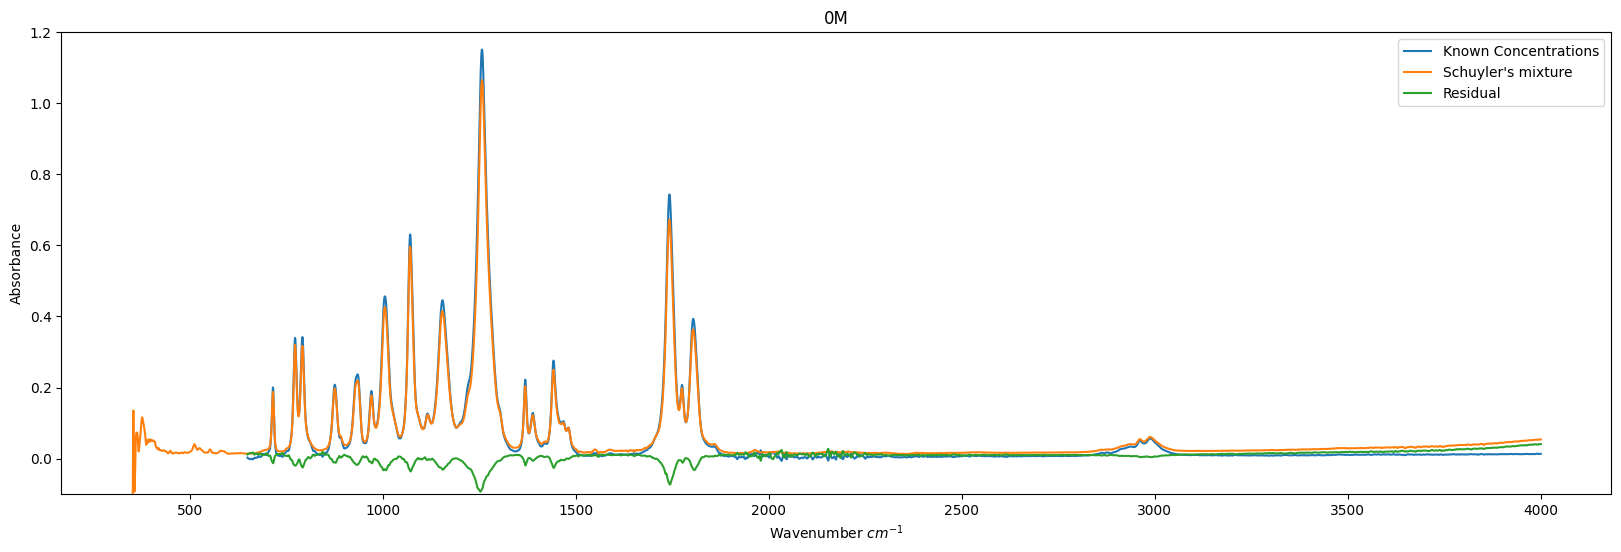

In [10]:
#Calculating percent error for 0M
plt.figure(figsize=(20,6))
plt.plot(wavenumbers,new_absorbances[:,0],label="Known Concentrations")
plt.plot(wn,A0,label="Schuyler's mixture")
#plt.xlim(400,2000)
plt.ylim(-0.1,1.2)
plt.ylabel("Absorbance")
plt.xlabel("Wavenumber $cm^{-1}$")

#Calculate the error
res0 = A0[slice(622,7572)] - new_absorbances[:,0]
err0 = res0/new_absorbances[:,0]
plt.plot(wavenumbers,res0,label="Residual")
plt.legend()
plt.title("0M")

Maximum error: 8.071%


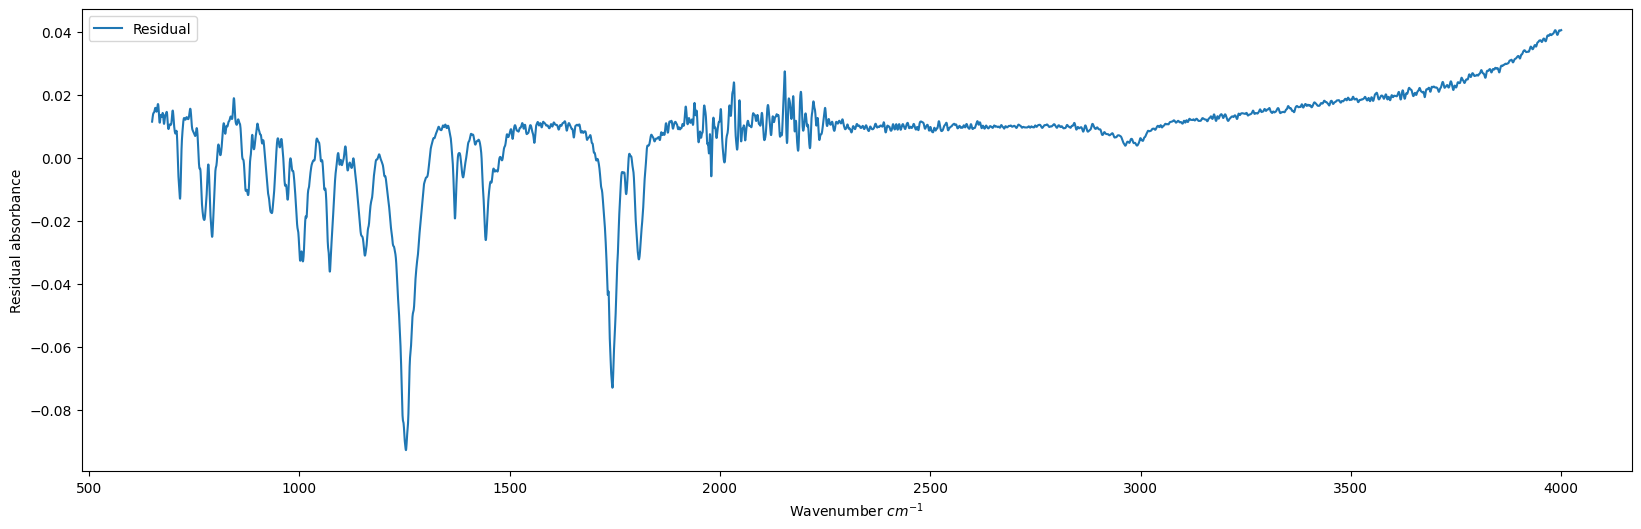

In [11]:
#Calculating percent error for 0M
plt.figure(figsize=(20,6))
plt.ylabel("Residual absorbance")
plt.xlabel("Wavenumber $cm^{-1}$")
plt.plot(wavenumbers,res0,label="Residual")
plt.legend()
max_error = max(abs(res0)) / max(new_absorbances[:,0]) * 100

print(f'Maximum error: {max_error:.3f}%')

In [12]:
print(new_concentrations)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6]


Text(0.5, 1.0, '.4M')

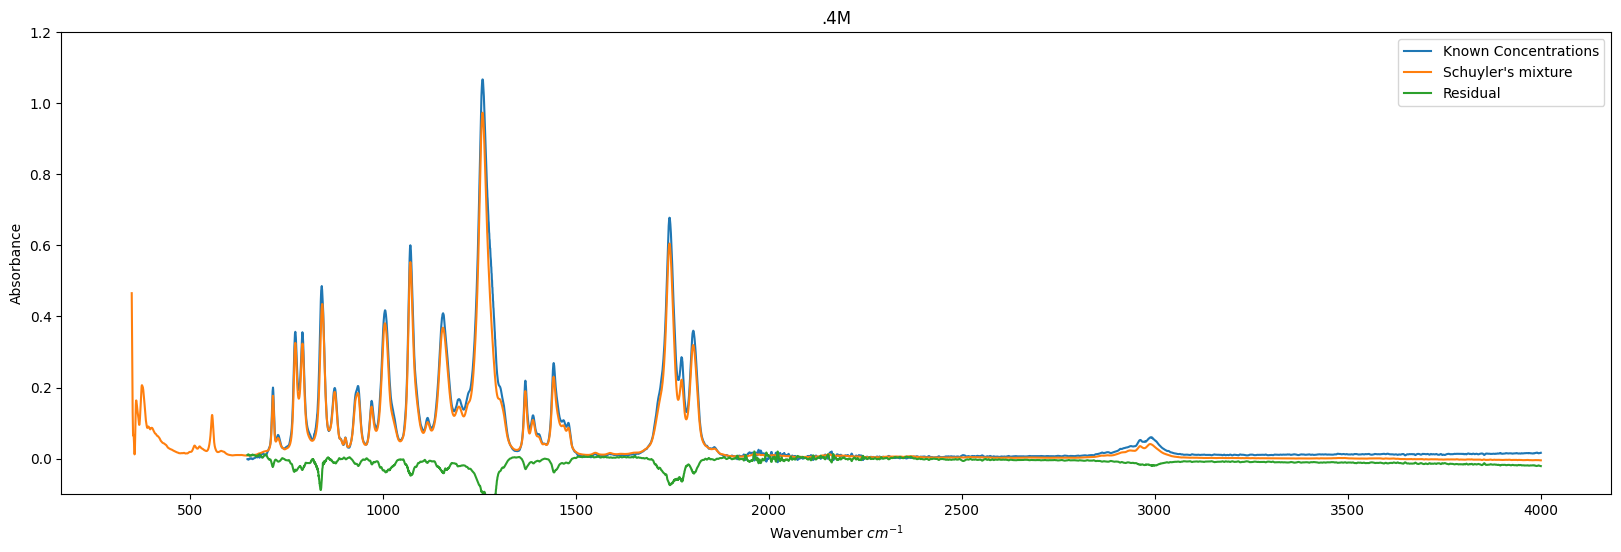

In [13]:
#Calculating percent error for .4M
plt.figure(figsize=(20,6))
plt.plot(wavenumbers,new_absorbances[:,4],label="Known Concentrations")
plt.plot(wn,A4,label="Schuyler's mixture")
#plt.xlim(400,2000)
plt.ylim(-0.1,1.2)
plt.ylabel("Absorbance")
plt.xlabel("Wavenumber $cm^{-1}$")

#Calculate the error
res4 = A4[slice(622,7572)] - new_absorbances[:,4]
err4 = res4/new_absorbances[:,4]
plt.plot(wavenumbers,res4,label="Residual")
plt.legend()
plt.title(".4M")

Maximum error: 14.080%


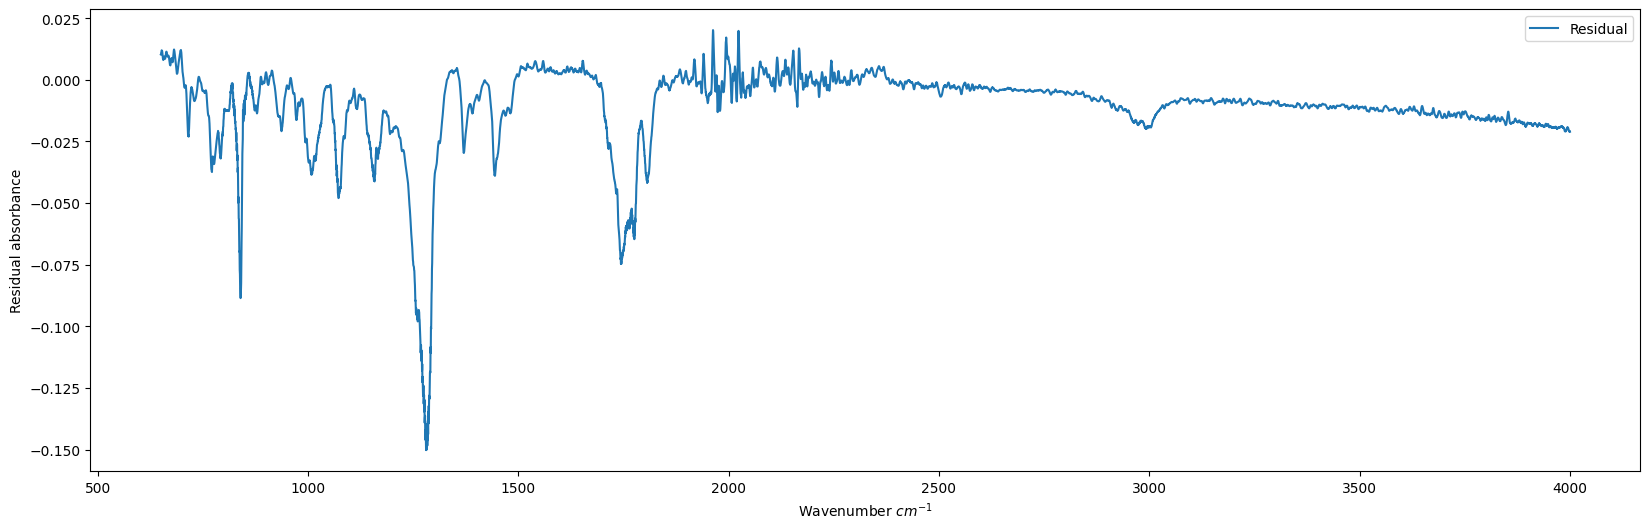

In [14]:
#Calculating percent error for .4M
plt.figure(figsize=(20,6))
plt.ylabel("Residual absorbance")
plt.xlabel("Wavenumber $cm^{-1}$")
plt.plot(wavenumbers,res4,label="Residual")
plt.legend()
max_error4 = max(abs(res4)) / max(new_absorbances[:,4]) * 100

print(f'Maximum error: {max_error4:.3f}%')

Text(0.5, 1.0, '.7M')

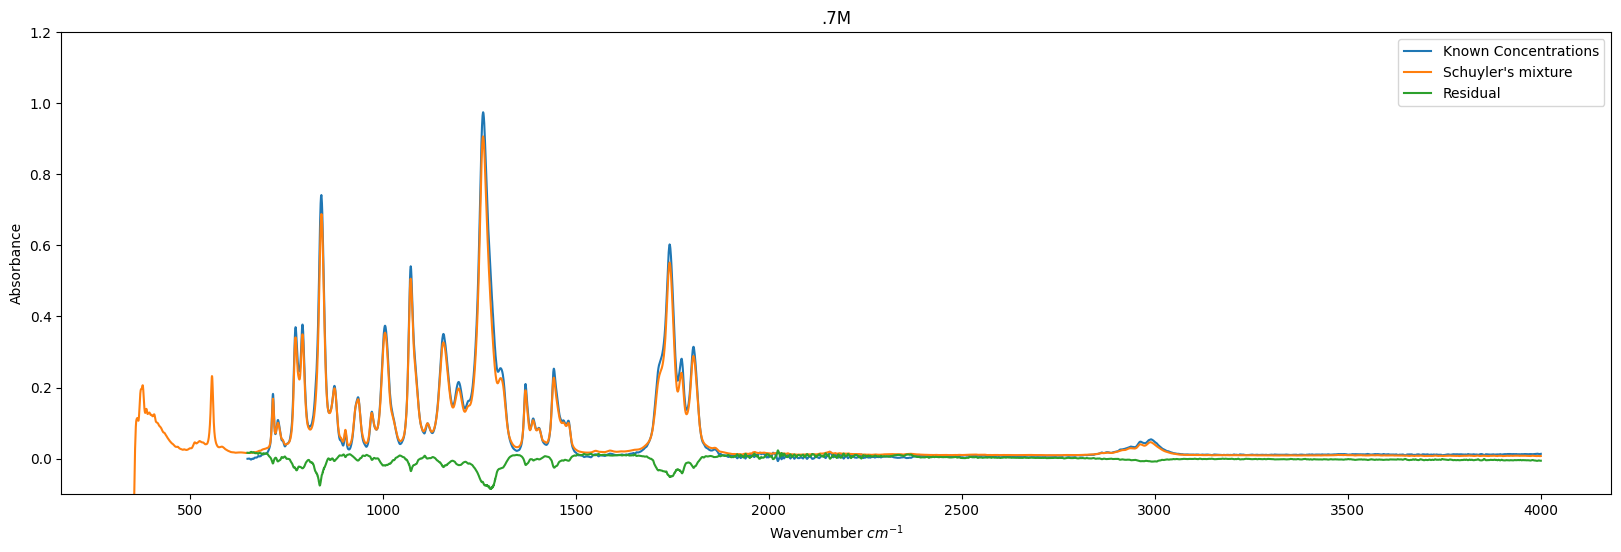

In [15]:
#Calculating percent error for .7M
plt.figure(figsize=(20,6))
plt.plot(wavenumbers,new_absorbances[:,7],label="Known Concentrations")
plt.plot(wn,A7,label="Schuyler's mixture")
#plt.xlim(400,2000)
plt.ylim(-0.1,1.2)
plt.ylabel("Absorbance")
plt.xlabel("Wavenumber $cm^{-1}$")

#Calculate the error
res7 = A7[slice(622,7572)] - new_absorbances[:,7]
err7 = res7/new_absorbances[:,7]
plt.plot(wavenumbers,res7,label="Residual")
plt.legend()
plt.title(".7M")

Maximum error: 8.737%


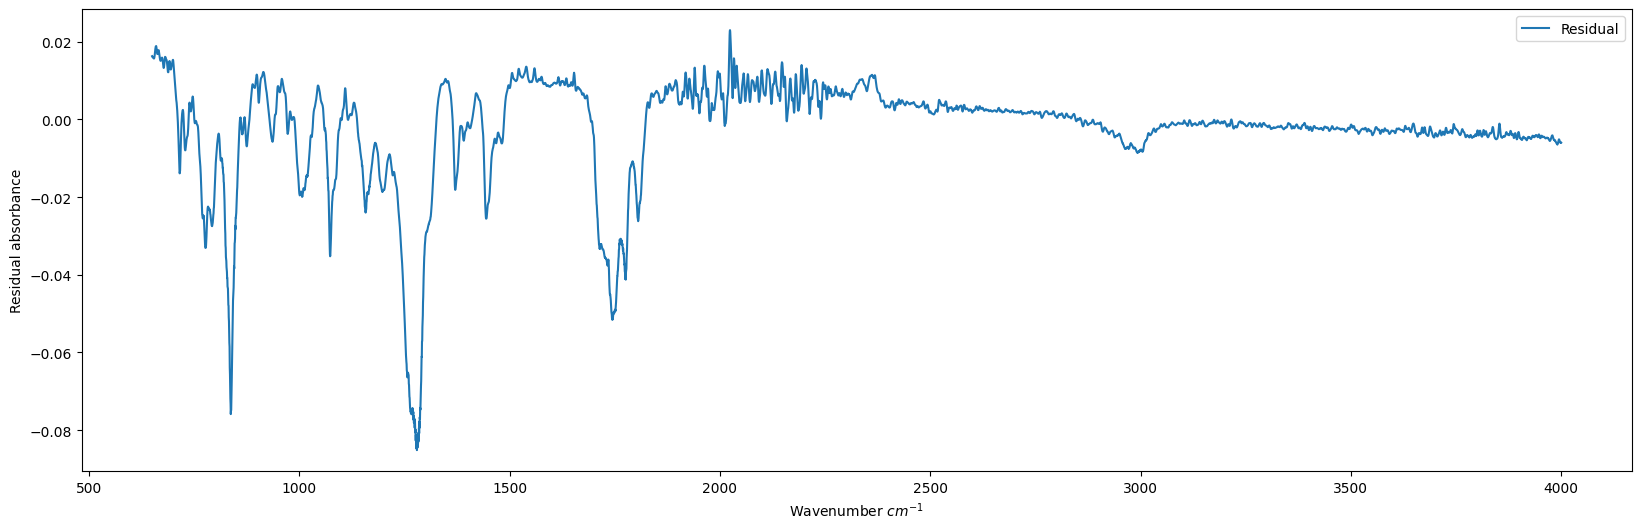

In [16]:
#Calculating percent error for .7M
plt.figure(figsize=(20,6))
plt.ylabel("Residual absorbance")
plt.xlabel("Wavenumber $cm^{-1}$")
plt.plot(wavenumbers,res7,label="Residual")
plt.legend()
max_error7 = max(abs(res7)) / max(new_absorbances[:,7]) * 100

print(f'Maximum error: {max_error7:.3f}%')

Text(0.5, 1.0, '1M')

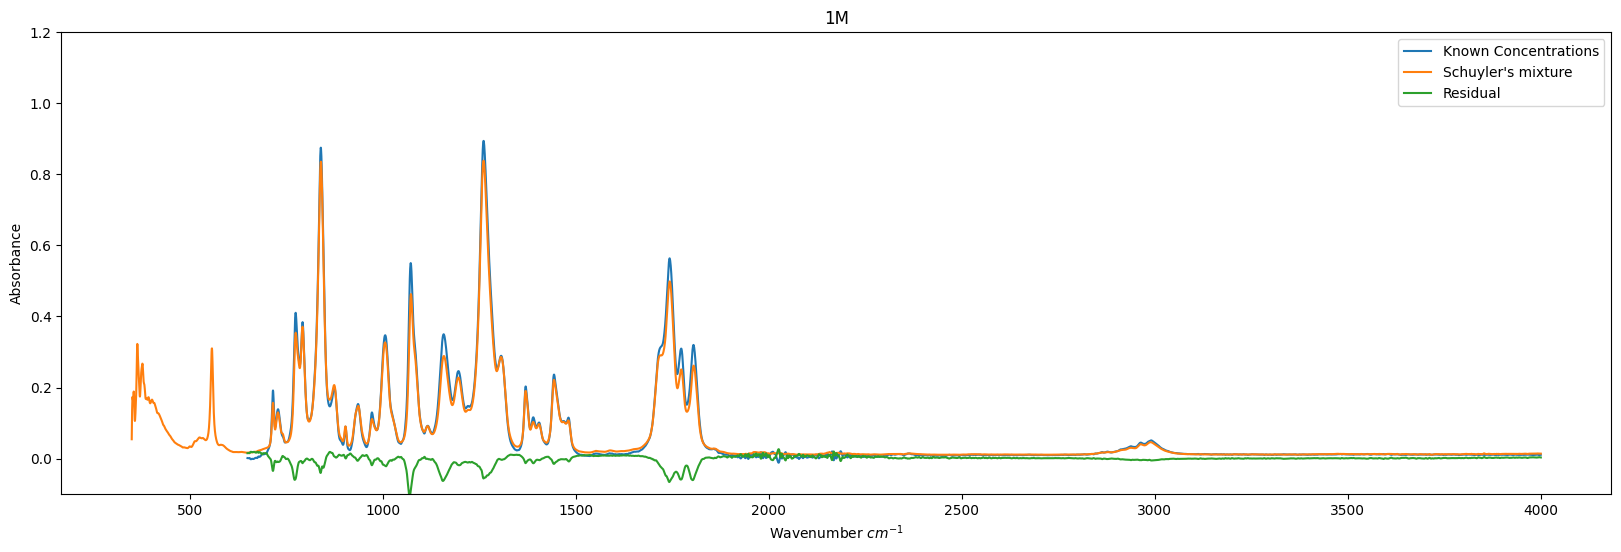

In [17]:
#Calculating percent error for 1M
plt.figure(figsize=(20,6))
plt.plot(wavenumbers,new_absorbances[:,10],label="Known Concentrations")
plt.plot(wn,A1,label="Schuyler's mixture")
#plt.xlim(400,2000)
plt.ylim(-0.1,1.2)
plt.ylabel("Absorbance")
plt.xlabel("Wavenumber $cm^{-1}$")

#Calculate the error
res1 = A1[slice(622,7572)] - new_absorbances[:,10]
err1 = res1/new_absorbances[:,10]
plt.plot(wavenumbers,res1,label="Residual")
plt.legend()
plt.title("1M")

Maximum error: 17.957%


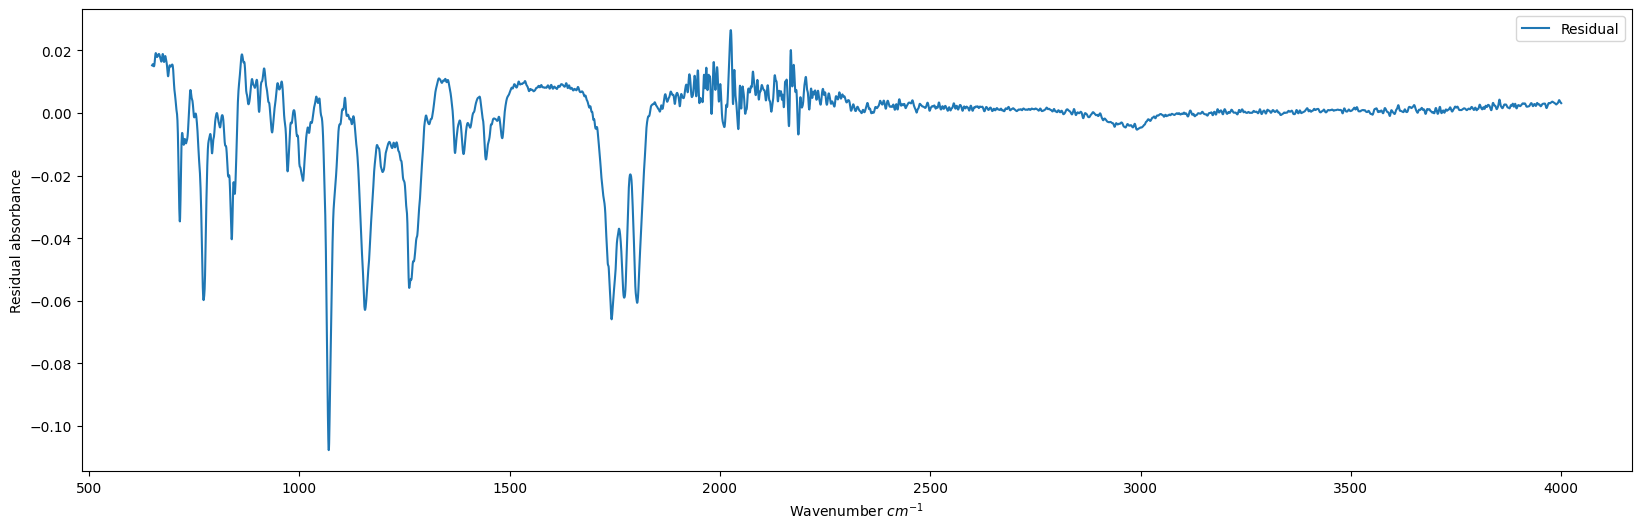

In [18]:
#Calculating percent error for 1M
plt.figure(figsize=(20,6))
plt.ylabel("Residual absorbance")
plt.xlabel("Wavenumber $cm^{-1}$")
plt.plot(wavenumbers,res1,label="Residual")
plt.legend()
max_error1 = max(abs(res1)) / .6 * 100

print(f'Maximum error: {max_error1:.3f}%')

Text(0.5, 1.0, '1.3M')

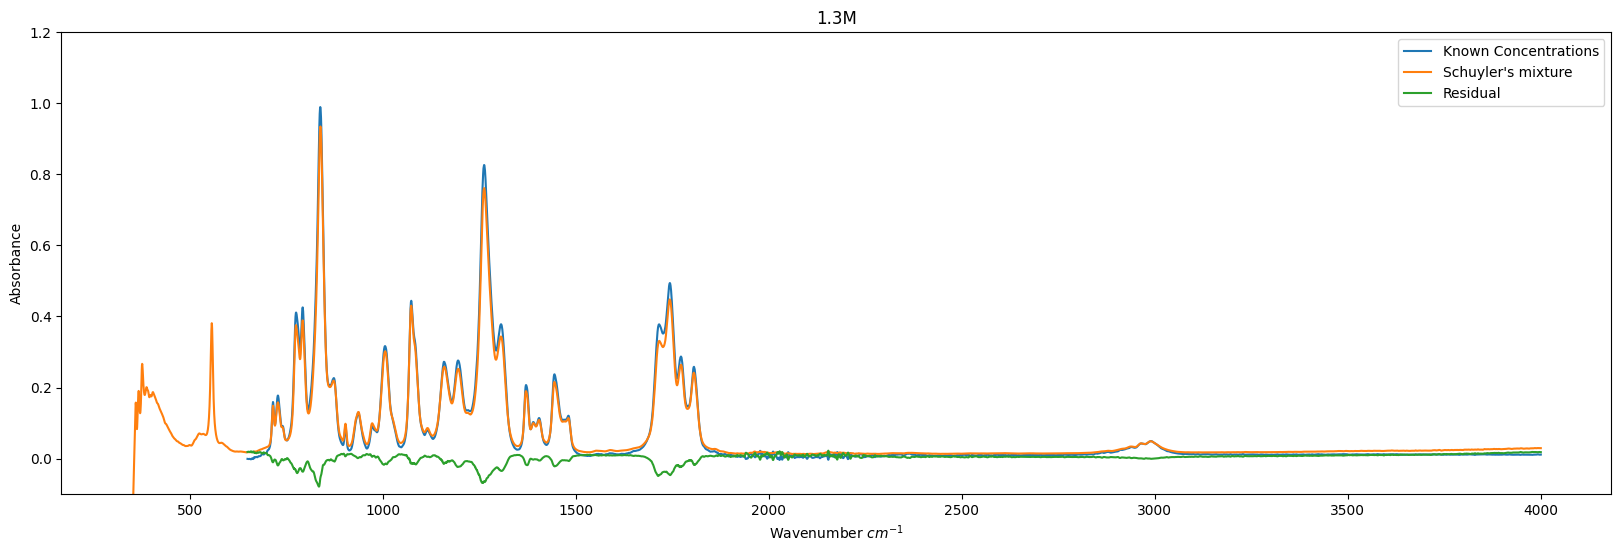

In [19]:
#Calculating percent error for 1.3M
plt.figure(figsize=(20,6))
plt.plot(wavenumbers,new_absorbances[:,13],label="Known Concentrations")
plt.plot(wn,A13,label="Schuyler's mixture")
#plt.xlim(400,2000)
plt.ylim(-0.1,1.2)
plt.ylabel("Absorbance")
plt.xlabel("Wavenumber $cm^{-1}$")

#Calculate the error
res13 = A13[slice(622,7572)] - new_absorbances[:,13]
err13 = res13/new_absorbances[:,13]
plt.plot(wavenumbers,res13,label="Residual")
plt.legend()
plt.title("1.3M")

Maximum error: 7.979%


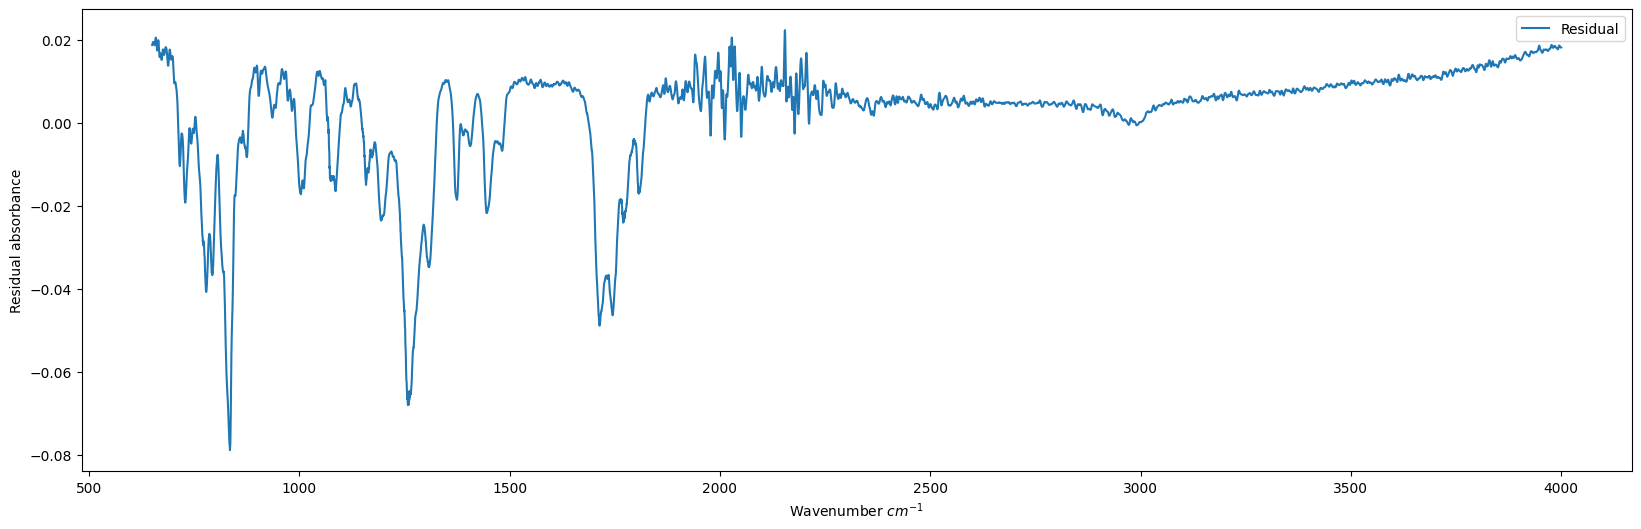

In [20]:
#Calculating percent error for 1.3M
plt.figure(figsize=(20,6))
plt.ylabel("Residual absorbance")
plt.xlabel("Wavenumber $cm^{-1}$")
plt.plot(wavenumbers,res13,label="Residual")
plt.legend()
max_error13 = max(abs(res13)) / max(new_absorbances[:,13]) * 100

print(f'Maximum error: {max_error13:.3f}%')

Text(0.5, 1.0, '1.6M')

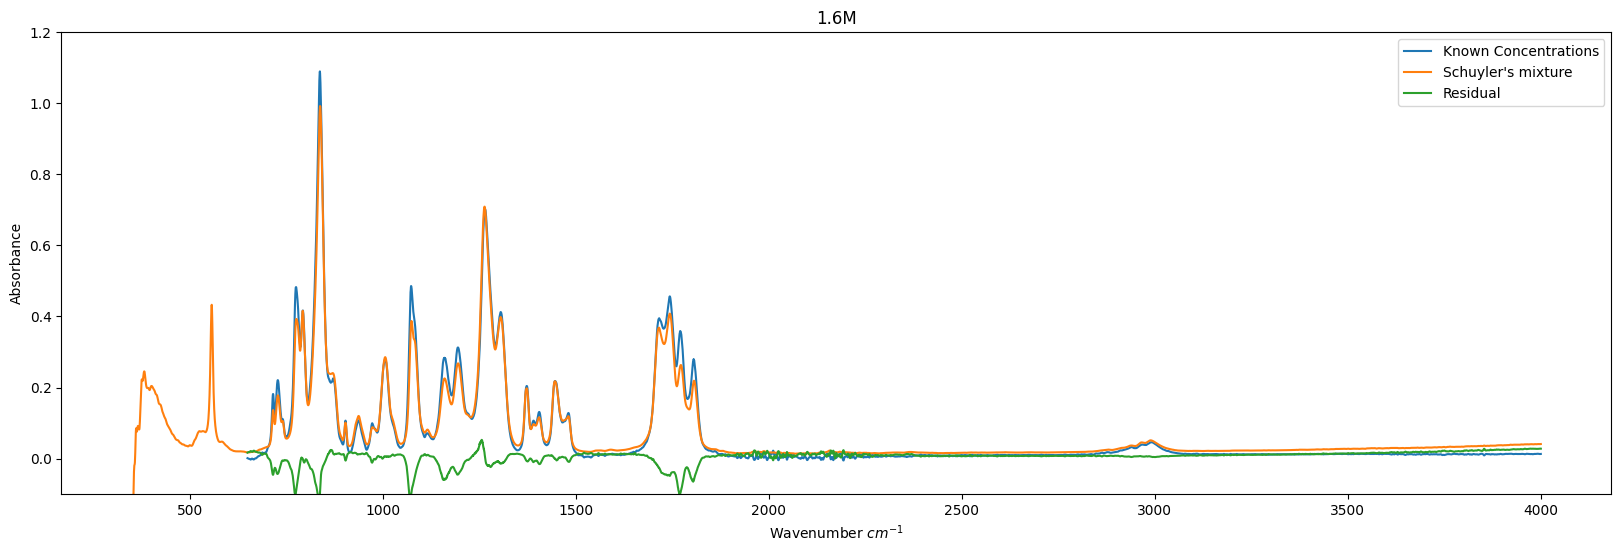

In [21]:
#Calculating percent error for 1.6M
plt.figure(figsize=(20,6))
plt.plot(wavenumbers,new_absorbances[:,16],label="Known Concentrations")
plt.plot(wn,A16,label="Schuyler's mixture")
#plt.xlim(400,2000)
plt.ylim(-0.1,1.2)
plt.ylabel("Absorbance")
plt.xlabel("Wavenumber $cm^{-1}$")

#Calculate the error
res16 = A16[slice(622,7572)] - new_absorbances[:,16]
err16 = res16/new_absorbances[:,16]
plt.plot(wavenumbers,res16,label="Residual")
plt.legend()
plt.title("1.6M")

Maximum error: 19.706%


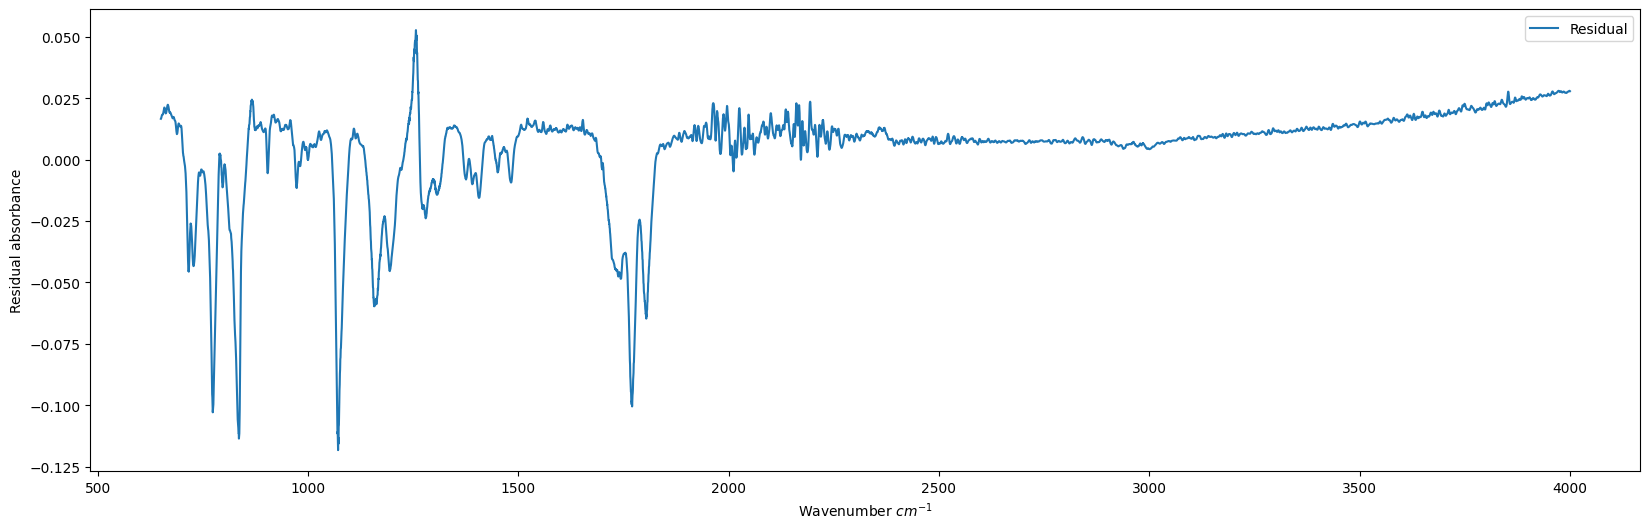

In [22]:
#Calculating percent error for 1.6M
plt.figure(figsize=(20,6))
plt.ylabel("Residual absorbance")
plt.xlabel("Wavenumber $cm^{-1}$")
plt.plot(wavenumbers,res16,label="Residual")
plt.legend()
max_error16 = max(abs(res16)) / .6 * 100

print(f'Maximum error: {max_error16:.3f}%')

0M as background:

Text(0.5, 1.0, 'Electrolyte ATR with 0M background')

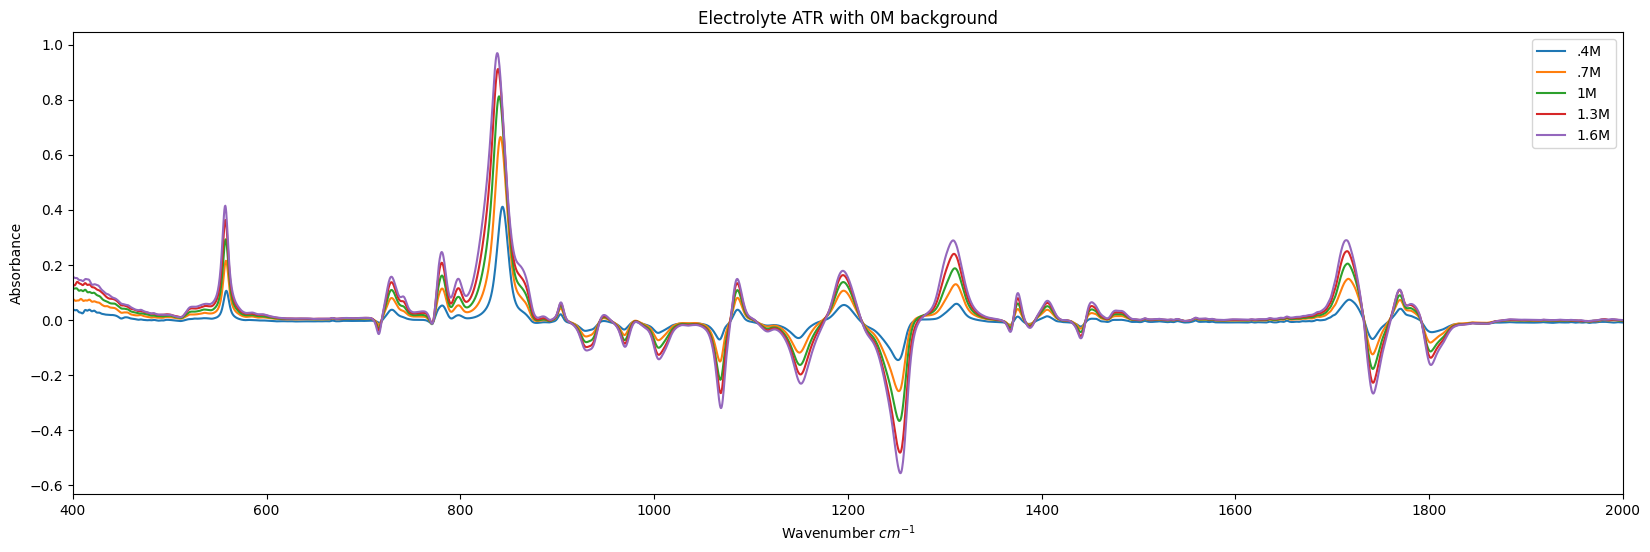

In [23]:
A42 = -np.log10(M4/M0)
A72 = -np.log10(M7/M0)
A12 = -np.log10(M1/M0)
A132 = -np.log10(M13/M0)
A162 = -np.log10(M16/M0)

plt.figure(figsize=(20,6))
plt.plot(wn,A42,label=".4M")
plt.plot(wn,A72,label=".7M")
plt.plot(wn,A12,label="1M")
plt.plot(wn,A132,label="1.3M")
plt.plot(wn,A162,label="1.6M")
plt.legend()
plt.xlim(400,2000)
#plt.ylim(0,1.2)
plt.ylabel("Absorbance")
plt.xlabel("Wavenumber $cm^{-1}$")
#print(len(wn))
plt.title("Electrolyte ATR with 0M background")

In [24]:
def find_index(ar, targ):
    array = np.asarray(ar)
    idx = (np.abs(array - targ)).argmin()
    return idx
def find_min(array, start, end):
    section = array[start:end]
    return min(section)
def find_max(array, start, end):
    section = array[start:end]
    return max(section)
print(find_index(wn,800))
help(np.trapz)

933
Help on function trapz in module numpy:

trapz(y, x=None, dx=1.0, axis=-1)
    Integrate along the given axis using the composite trapezoidal rule.
    
    If `x` is provided, the integration happens in sequence along its
    elements - they are not sorted.
    
    Integrate `y` (`x`) along each 1d slice on the given axis, compute
    :math:`\int y(x) dx`.
    When `x` is specified, this integrates along the parametric curve,
    computing :math:`\int_t y(t) dt =
    \int_t y(t) \left.\frac{dx}{dt}\right|_{x=x(t)} dt`.
    
    Parameters
    ----------
    y : array_like
        Input array to integrate.
    x : array_like, optional
        The sample points corresponding to the `y` values. If `x` is None,
        the sample points are assumed to be evenly spaced `dx` apart. The
        default is None.
    dx : scalar, optional
        The spacing between sample points when `x` is None. The default is 1.
    axis : int, optional
        The axis along which to integrate.
    
 